In [1]:
#mixup.py
import math
import random

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.datasets import mnist, cifar10
from keras.layers import Activation, Input, Dense, Conv2D, LeakyReLU
from keras.layers import Dropout, BatchNormalization, Flatten, Reshape, SpatialDropout2D

Using TensorFlow backend.


In [2]:
def _mixup_batch(in_batch: np.ndarray, out_batch: np.ndarray, alpha: int = 1.0):
    """Mixup the batch by sampling from a beta distribution and 
    computing a weighted average of the first half of the batch with last half."""
    half = in_batch.shape[0] // 2
    mixed_ins = np.zeros((half,) + in_batch.shape[1:])
    mixed_outs = np.zeros((half,) + out_batch.shape[1:])
    for i in range(half):
        weight0 = np.random.beta(alpha, alpha)
        weight1 = 1 - weight0
        mixed_ins[i] = (in_batch[i, ...] * weight0) + (in_batch[half+i, ...] * weight1)
        mixed_outs[i] = (out_batch[i, ...] * weight0) + (out_batch[half+i, ...] * weight1)

    return mixed_ins, mixed_outs

In [3]:
def load_mnist():
    img_rows, img_cols = 28, 28

    # the data, shuffled and split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1).astype('float32')
    x_train /= 128.0
    x_test /= 128.0
    x_train -= 1.0
    x_test -= 1.0
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    print('bounds:', np.min(x_train), np.max(x_train))
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print('y_train shape:', y_train.shape)
    print('y_train sum:', np.sum(y_train, axis=0))
    return (x_train, y_train), (x_test, y_test)

In [4]:
def load_cifar():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255.0
    x_test /= 255.0
    #x_train -= 1.0
    #x_test -= 1.0
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    print('bounds:', np.min(x_train), np.max(x_train))
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')	
    return (x_train, y_train), (x_test, y_test)

In [5]:
def _plot_batch(image_batch):
    batch_size = image_batch.shape[0]
    sqrt_batch = int(math.sqrt(batch_size))
    _, axes = plt.subplots(sqrt_batch, sqrt_batch, figsize=(18, 14))
    for i in range(batch_size):
        if image_batch.shape[-1] == 1:
            axes[i//sqrt_batch, i%sqrt_batch].imshow(image_batch[i, :, :, 0])
        else:
            axes[i//sqrt_batch, i%sqrt_batch].imshow(image_batch[i, ...])

In [6]:
def build_discriminative_model(in_shape, out_classes):
    d_input = Input(in_shape)
    H = Conv2D(128, (3, 3), strides=(2,2), padding='same', kernel_regularizer=l2(0.001))(d_input)
    H = BatchNormalization(momentum=0.9)(H)
    H = LeakyReLU(0.2)(H)
    H = Conv2D(64, (3, 3), strides=(2,2), padding='same', kernel_regularizer=l2(0.001))(H)
    H = BatchNormalization(momentum=0.9)(H)
    H = LeakyReLU(0.2)(H)
    H = Flatten()(H)
    H = Dense(32, kernel_regularizer=l2(0.001))(H)
    H = BatchNormalization(momentum=0.9)(H)
    d_V = Dense(out_classes, activation='softmax', kernel_regularizer=l2(0.001))(H)
    discriminator = Model(d_input, d_V)
    discriminator.compile(loss='categorical_crossentropy', optimizer='adam')
    discriminator.summary()
    return discriminator

mnist_discriminator = build_discriminative_model((28, 28, 1), 10)
cifar_discriminator = build_discriminative_model((32, 32, 3), 10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

In [7]:
def _accuracy_on_batch(discriminator, batch, y):
    y_hat = discriminator.predict(batch)
    y_hat_idx = np.argmax(y_hat, axis=-1)
    y_idx = np.argmax(y, axis=-1)
    diff = y_idx-y_hat_idx
    n_tot = y.shape[0]
    n_rig = (diff==0).sum()
    acc = n_rig*100.0/n_tot
    print(f'y true sum:{[int(num) for num in np.sum(y, axis=0)]}. Accuracy: {acc:0.02f} pct ({n_rig} of {n_tot}).')
    print(f'y pred sum:{[int(num) for num in np.sum(y_hat, axis=0)]}')

bounds: -1.0 0.9921875
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
y_train shape: (60000, 10)
y_train sum: [5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]
y true sum:[8, 7, 8, 8, 8, 5, 7, 4, 7, 2]. Accuracy: 64.06 pct (41 of 64).
y pred sum:[8, 5, 10, 8, 7, 4, 4, 3, 6, 4]
epoch 0 with loss 3.110811710357666
y true sum:[7, 4, 4, 13, 4, 7, 4, 7, 11, 3]. Accuracy: 81.25 pct (52 of 64).
y pred sum:[7, 4, 6, 11, 6, 4, 4, 4, 11, 4]
epoch 5 with loss 1.1604546308517456


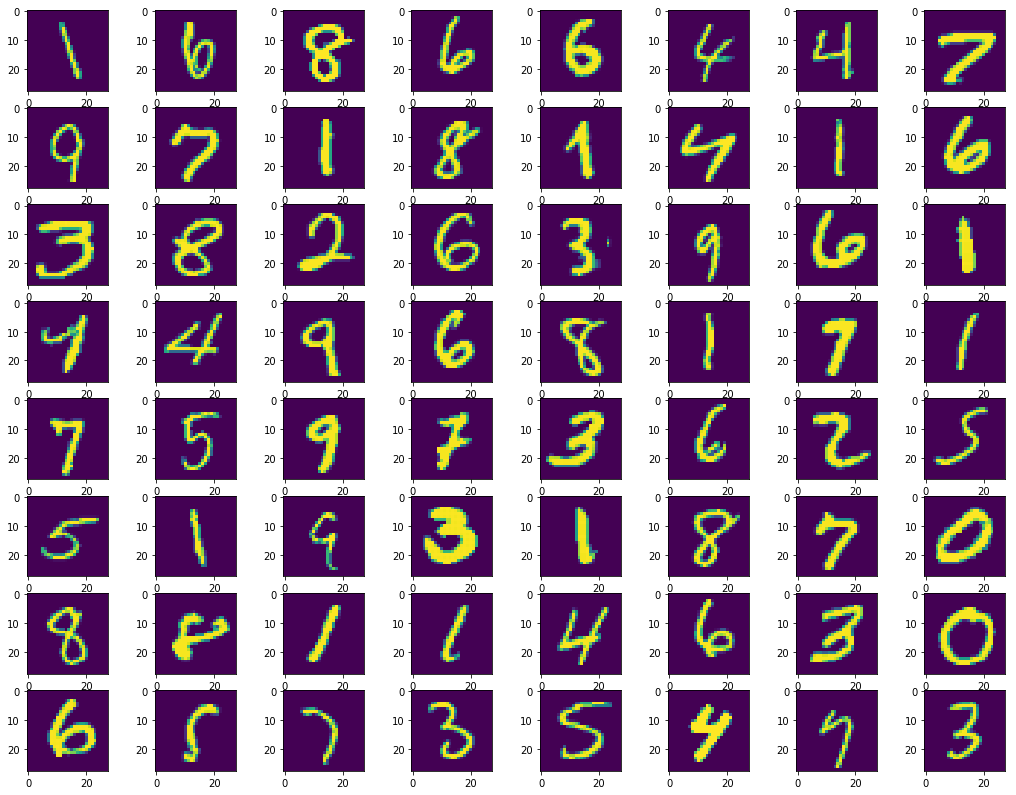

In [8]:
def _train_on_batches(discriminator, x_train, y_train, epochs, batch_size, mixup=False, alpha=1.0):
    if mixup:
        batch_size *= 2
    for e in range(epochs):
        indexes = np.random.randint(0, x_train.shape[0], size=batch_size)
        image_batch = x_train[indexes, ...] 
        class_label = y_train[indexes, ...]
        if mixup:
            image_batch, class_label = _mixup_batch(image_batch, class_label, alpha)
        d_loss = discriminator.train_on_batch(image_batch, class_label)
        if e%5 == 0:
            _accuracy_on_batch(discriminator, image_batch, class_label)
            print(f'epoch {e} with loss {d_loss}')
    _plot_batch(image_batch)
            
(mnist_x, mnist_y), _ = load_mnist()            
_train_on_batches(mnist_discriminator, mnist_x, mnist_y, 10, 64, mixup=False)

y true sum:[7, 7, 6, 9, 4, 8, 5, 5, 6, 2]. Accuracy: 57.81 pct (37 of 64).
y pred sum:[8, 6, 7, 5, 6, 6, 5, 3, 12, 3]
epoch 0 with loss 1.7299854755401611
y true sum:[2, 7, 10, 5, 8, 5, 6, 3, 7, 6]. Accuracy: 78.12 pct (50 of 64).
y pred sum:[2, 7, 11, 2, 8, 4, 7, 2, 11, 5]
epoch 5 with loss 1.4941074848175049


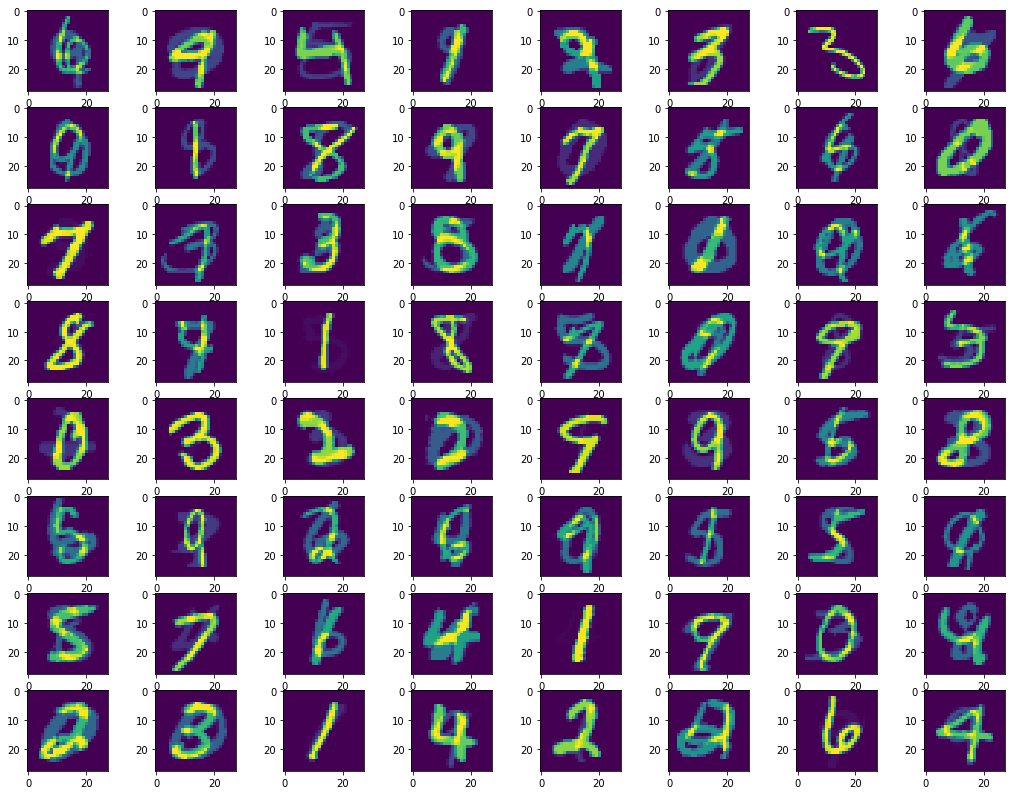

In [9]:
_train_on_batches(mnist_discriminator, mnist_x, mnist_y, 10, 64, mixup=True)

y true sum:[4, 6, 4, 5, 9, 4, 7, 7, 7, 6]. Accuracy: 81.25 pct (52 of 64).
y pred sum:[5, 6, 6, 3, 9, 5, 7, 7, 7, 5]
epoch 0 with loss 1.116590976715088
y true sum:[5, 10, 5, 3, 8, 8, 3, 8, 2, 6]. Accuracy: 85.94 pct (55 of 64).
y pred sum:[5, 9, 5, 2, 8, 8, 4, 7, 4, 7]
epoch 5 with loss 1.0205910205841064


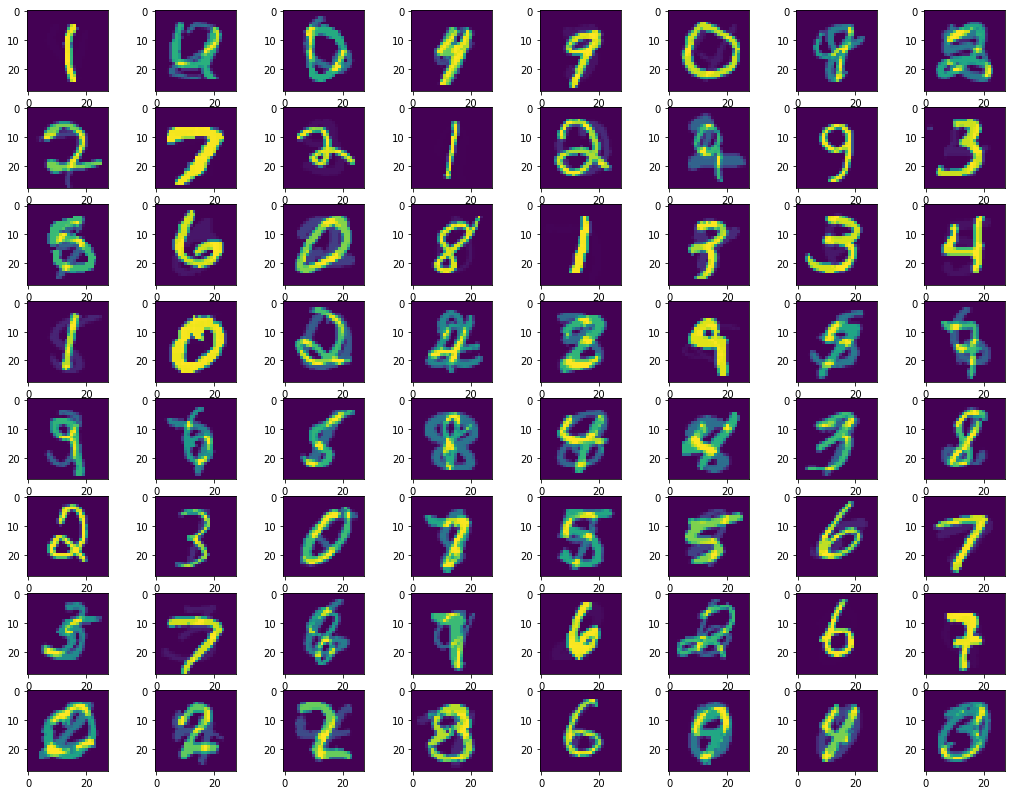

In [10]:
_train_on_batches(mnist_discriminator, mnist_x, mnist_y, 10, 64, mixup=True, alpha=0.5)

y true sum:[4, 8, 6, 9, 7, 5, 4, 5, 5, 7]. Accuracy: 65.62 pct (42 of 64).
y pred sum:[4, 8, 7, 7, 7, 4, 4, 5, 7, 5]
epoch 0 with loss 1.4466804265975952
y true sum:[3, 10, 6, 10, 6, 6, 4, 6, 4, 4]. Accuracy: 73.44 pct (47 of 64).
y pred sum:[2, 7, 9, 9, 6, 4, 5, 4, 8, 5]
epoch 5 with loss 1.4882806539535522


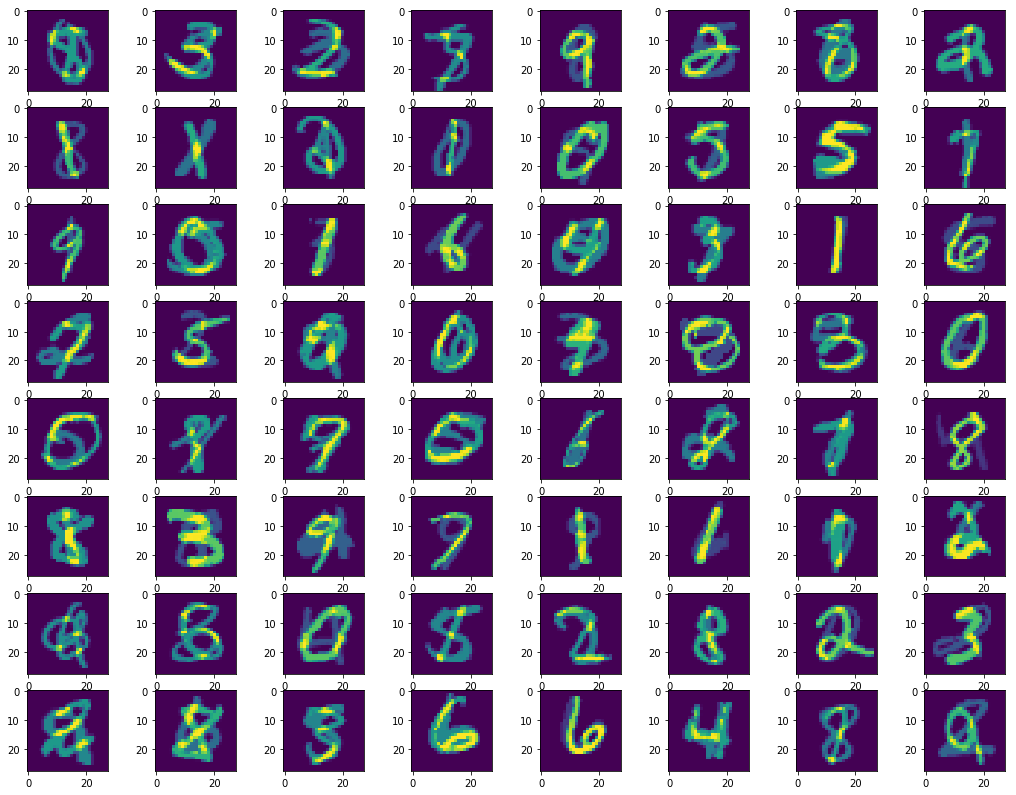

In [11]:
_train_on_batches(mnist_discriminator, mnist_x, mnist_y, 10, 64, mixup=True, alpha=5.0)

y true sum:[5, 8, 9, 7, 4, 6, 3, 7, 5, 5]. Accuracy: 48.44 pct (31 of 64).
y pred sum:[6, 7, 9, 5, 5, 4, 7, 7, 6, 3]
epoch 0 with loss 1.6118401288986206
y true sum:[5, 4, 5, 4, 6, 5, 8, 9, 8, 4]. Accuracy: 45.31 pct (29 of 64).
y pred sum:[5, 4, 6, 4, 8, 5, 9, 9, 5, 3]
epoch 5 with loss 1.6536188125610352


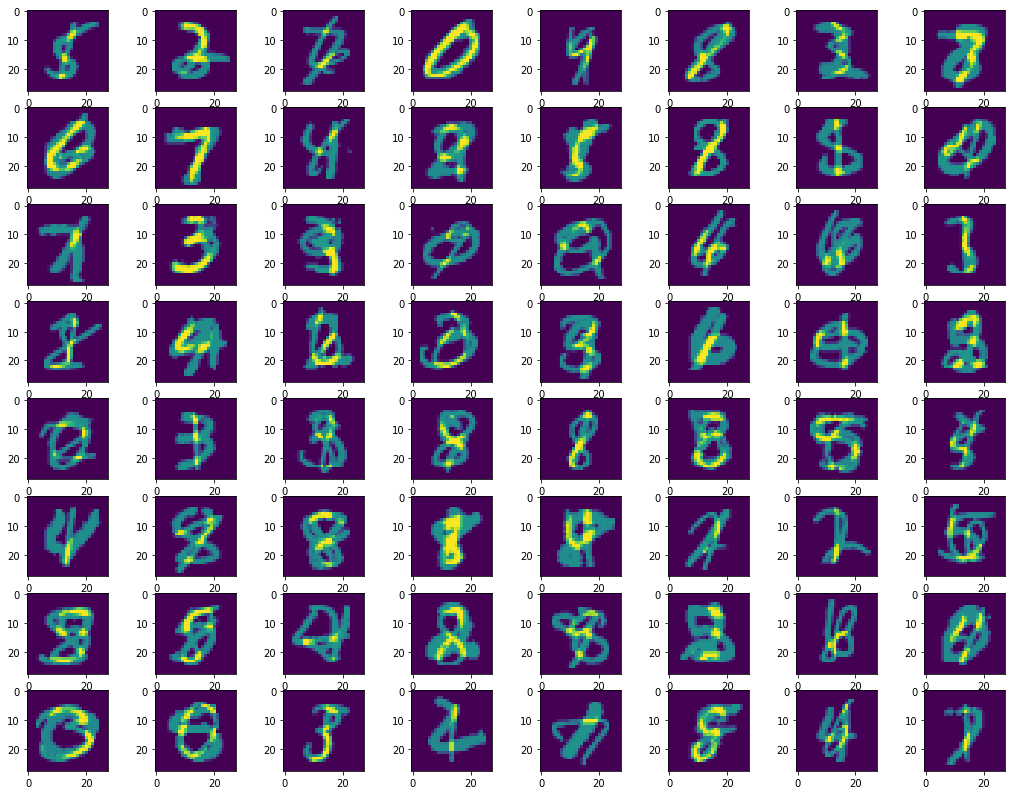

In [12]:
_train_on_batches(mnist_discriminator, mnist_x, mnist_y, 10, 64, mixup=True, alpha=500.0)

bounds: 0.0 1.0
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y true sum:[14, 8, 11, 10, 6, 11, 9, 16, 10, 5]. Accuracy: 26.00 pct (26 of 100).
y pred sum:[8, 4, 22, 5, 2, 3, 9, 11, 10, 21]
epoch 0 with loss 3.1736724376678467
y true sum:[12, 4, 16, 6, 8, 14, 7, 15, 10, 8]. Accuracy: 23.00 pct (23 of 100).
y pred sum:[2, 12, 3, 11, 9, 10, 6, 17, 11, 15]
epoch 5 with loss 2.450326681137085


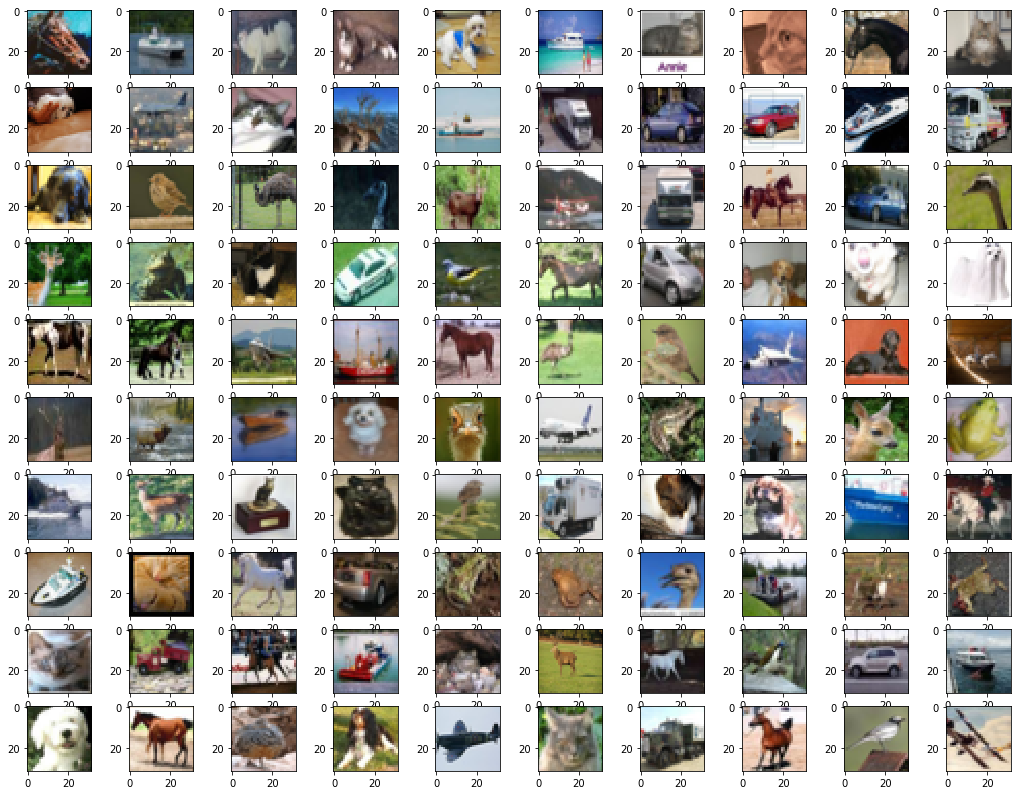

In [13]:
(cifar_x, cifar_y), _ = load_cifar()            
_train_on_batches(cifar_discriminator, cifar_x, cifar_y, 10, 100, mixup=False)

y true sum:[1, 3, 1, 0, 1, 1, 1, 2, 2, 0]. Accuracy: 37.50 pct (6 of 16).
y pred sum:[1, 1, 0, 1, 1, 1, 1, 2, 1, 3]
epoch 0 with loss 2.3840837478637695


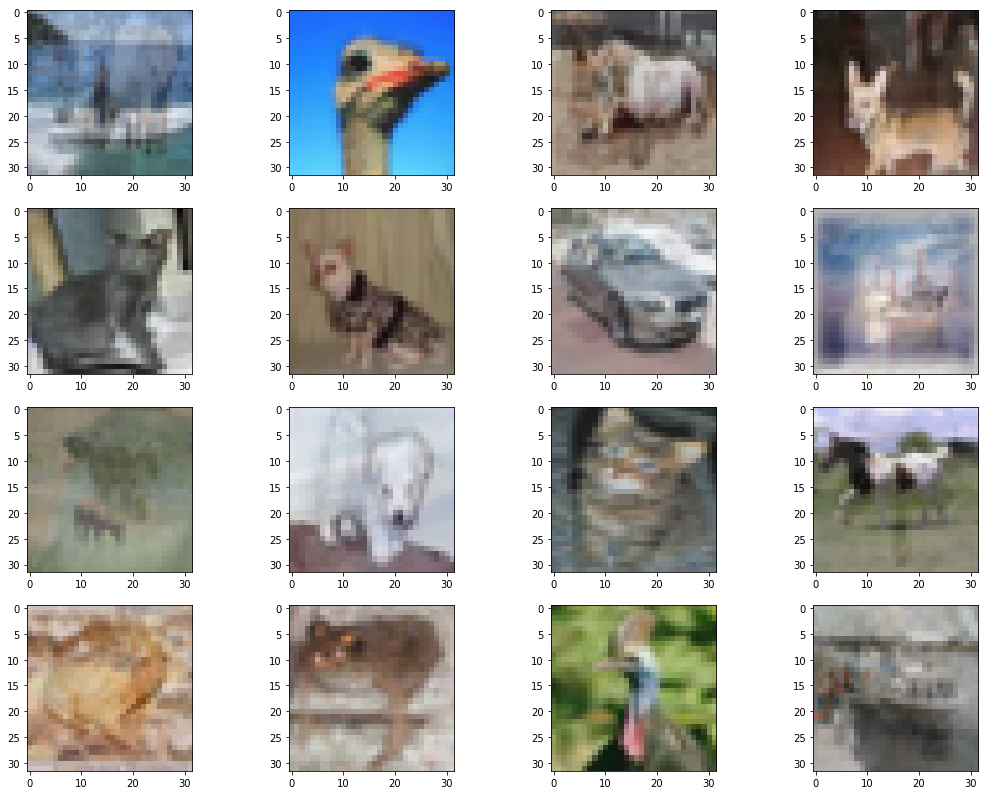

In [14]:
_train_on_batches(cifar_discriminator, cifar_x, cifar_y, 5, 16, mixup=True)

y true sum:[24, 23, 19, 24, 25, 17, 20, 20, 25, 23]. Accuracy: 19.11 pct (43 of 225).
y pred sum:[11, 18, 14, 11, 16, 36, 25, 45, 14, 29]
epoch 0 with loss 2.353503465652466


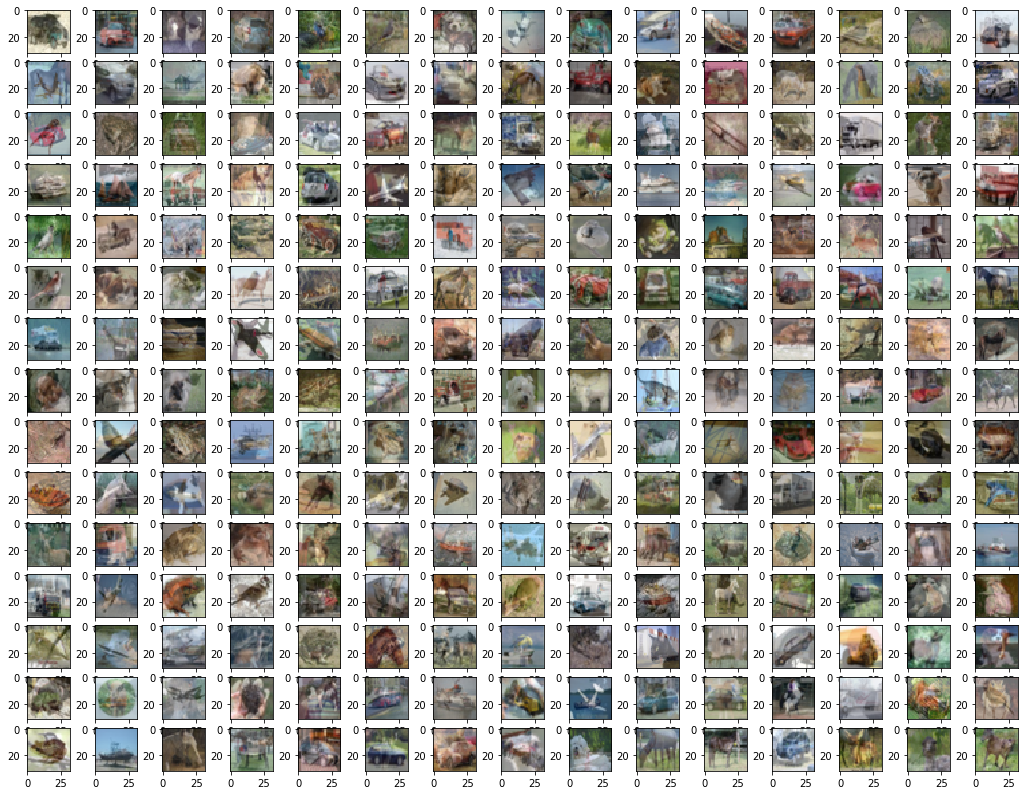

In [15]:
_train_on_batches(cifar_discriminator, cifar_x, cifar_y, 5, 225, mixup=True, alpha=500)

y true sum:[22, 22, 26, 24, 19, 19, 23, 19, 20, 25]. Accuracy: 22.67 pct (51 of 225).
y pred sum:[13, 22, 15, 11, 15, 37, 29, 37, 11, 31]
epoch 0 with loss 2.276648759841919
y true sum:[25, 23, 22, 23, 16, 16, 25, 24, 23, 23]. Accuracy: 32.44 pct (73 of 225).
y pred sum:[21, 19, 22, 13, 16, 27, 29, 32, 13, 28]
epoch 5 with loss 2.1148858070373535
y true sum:[22, 21, 23, 19, 26, 22, 23, 22, 25, 17]. Accuracy: 32.44 pct (73 of 225).
y pred sum:[22, 18, 22, 17, 20, 25, 35, 28, 14, 18]
epoch 10 with loss 2.1207640171051025


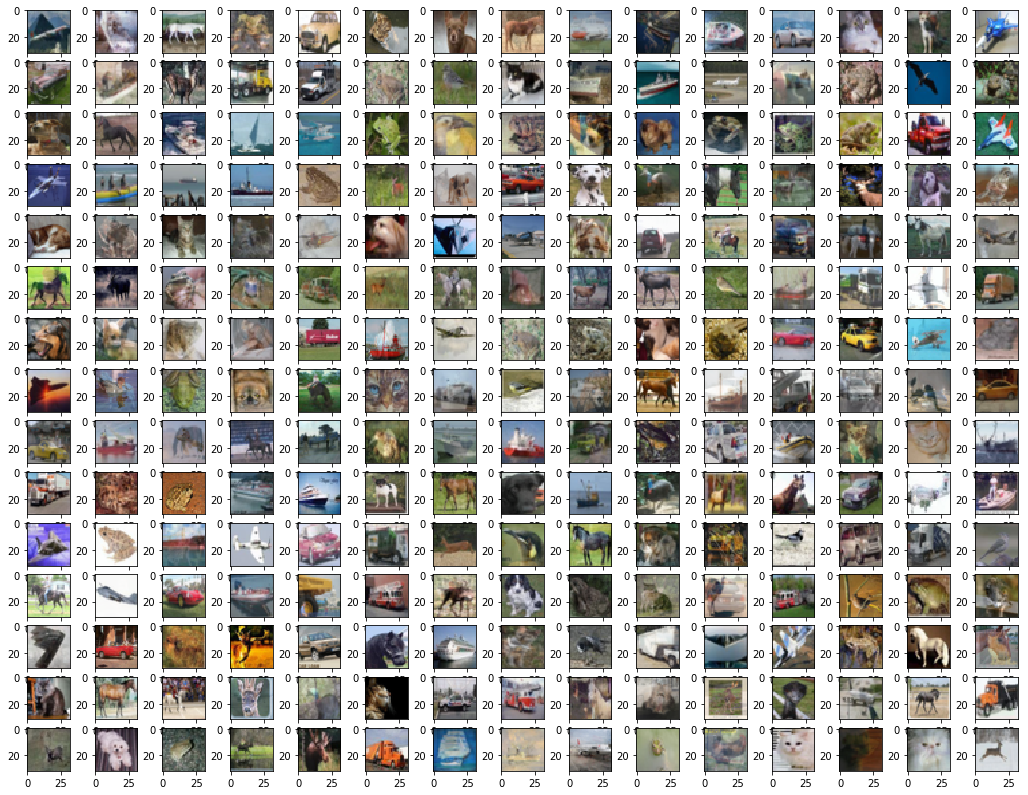

In [16]:
_train_on_batches(cifar_discriminator, cifar_x, cifar_y, 15, 225, mixup=True, alpha=0.5)